# CS109b Final Project: 
# Air Pollution Exposure and COVID-19 Mortality in the U.S.

## Import libraries

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import plotly.figure_factory as ff

pd.options.display.max_rows = 500
pd.options.display.max_columns = 500

## Load and clean data

In [2]:
data = pd.read_csv("./../PM_COVID-master/processed_data_04-24-2020.csv")

In [3]:
#load data
#data = pd.read_csv('https://raw.githubusercontent.com/CS109b-Team37/Pollution-Prediction/master/PM_COVID-master/processed_data_04-24-2020.csv')

In [4]:
#rename older_pecent to older_percent
data = data.rename(columns={'older_pecent': 'older_percent'})

#drop columns
cols = list(data.columns)
cols.remove('Unnamed: 0') #just a column of integers 1-21560
#cols.remove('Province_State') #redundant information; already captured by 'state'
cols.remove('Country_Region') #only US
cols.remove('Combined_Key') #redundant information; already captured by 'Province_State' and 'Admin2'
cols.remove('year.x') #only 2016
cols.remove('year.y') #only 2012 and nan
cols.remove('Population') #'older_pecent' was calculated by Population/older_Population
cols.remove('older_Population') #'older_pecent' was calculated by Population/older_Population
cols.remove('date') #only 20200502
cols.remove('hash') #useless information
cols.remove('dateChecked') #only '2020-05-02T20:00:00Z'
cols.remove('Abbrev') #redundant information; already captured by 'state'
cols.remove('total') #almost a repeat of 'totalTestResults'
cols.remove('Recovered') #only 0
data = data[cols]


In [5]:
data['Last_Update'].unique()

array(['2020-04-25 06:30:53', '3/30/20 22:52', '2020-04-25 06:31:05',
       '2020-04-23 00:00:00', '2020-04-24 00:00:00'], dtype=object)

In [6]:
#convert Last_Update to binary variable
convert_dict = {'2020-05-03 02:32:28': 0, '3/30/20 22:52': 1}
data = data.replace({'Last_Update': convert_dict})


In [7]:
#variables with NA values
print('Variables with NA values:')
display(data.isna().sum()[data.isna().sum() > 0])

#remove variables with many NA values
na_vars = list(data.isna().sum()[data.isna().sum() > 50].index) #variables with many NA values
data = data[set(cols) - set(na_vars)] #final cleaned data

Variables with NA values:


smoke_rate                 867
mean_bmi                   867
Crude.Rate                   1
older_percent                1
pending                   2819
hospitalizedCurrently      898
hospitalizedCumulative    1284
inIcuCurrently            1808
inIcuCumulative           2608
onVentilatorCurrently     2155
onVentilatorCumulative    2944
recovered                 1479
hospitalized              1284
beds                       811
dtype: int64

In [8]:
#both NA values are for Loving, Texas
null_data = data[data.isnull().any(axis=1)]
print('Rows with NA values:')
display(null_data)

#fill in NA values for 'Crude.Rate' and 'older_percent' with state average
values = {'Crude.Rate': data.groupby('state').mean()['Crude.Rate']['TX'], 'older_percent': data.groupby('state').mean()['older_percent']['TX']}
data = data.fillna(value=values)

Rows with NA values:


,hospitalizedIncrease,mean_summer_rm,Admin2,posNeg,Last_Update,negativeIncrease,q_popdensity,totalTestResults,pct_native,popdensity,Province_State,older_percent,totalTestResults_county,Active,hispanic,fips,totalTestResultsIncrease,Long_,positive,population,population_frac_county,deathIncrease,mean_pm25,Crude.Rate,poverty,mean_summer_temp,negative,death,Lat,mean_winter_rm,education,mean_winter_temp,Confirmed,pct_owner_occ,medhouseholdincome,medianhousevalue,pct_asian,state,positiveIncrease,Deaths,pct_white,pct_blk
2635,0,73.844694,Loving,242547,1,16607,1,242547,0.047619,0.395035,Texas,NaN,0.567672,0,0.142857,48301,17469,-103.581857,22806,63,0.000002,32,5.685412,NaN,0.631579,309.483185,219741,593,31.849476,72.837808,0.526316,290.213523,0,0.485714,55625.0,89040.0,0.0,TX,862,0,0.857143,0.0


## Add in NY Times County Data with Cumulative Daily Coronavirus Cases & Deaths

In [588]:
url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv'
df_nytimes = pd.read_csv(url,index_col=0,parse_dates=[0])

In [589]:
df_nytimes.shape

(126835, 5)

In [590]:
df_nytimes_today = df_nytimes.loc[df_nytimes.index=='2020-05-02']

print("Deaths in counties with NULL FIPS: ", 
      df_nytimes_today.loc[df_nytimes_today['fips'].isnull()==True]['deaths'].sum(),
     '| Number of counties: ', len(df_nytimes_today.loc[df_nytimes_today['fips'].isnull()==True]))


print("Deaths in New York County (biggest area with NULL FIPS): ", 
      df_nytimes_today.loc[df_nytimes_today['county']=='New York City']['deaths'].sum())

print("Deaths in counties with correct FIPS: ", 
      df_nytimes_today.loc[df_nytimes_today['fips'].isnull()==False]['deaths'].sum(),
     '| Number of counties: ', len(df_nytimes_today.loc[df_nytimes_today['fips'].isnull()==False]))

print("Total Deaths: ", df_nytimes_today['deaths'].sum(),
          '| Number of counties: ', len(df_nytimes_today))


Deaths in counties with NULL FIPS:  18424 | Number of counties:  28
Deaths in New York County (biggest area with NULL FIPS):  18021
Deaths in counties with correct FIPS:  48031 | Number of counties:  2837
Total Deaths:  66455 | Number of counties:  2865


In [591]:
data['fips_new']=data['fips'].astype(int).apply(lambda x: '{0:0>5}'.format(x)) #add leading zeros to fips code
#data['fips_new']=data['fips'].astype(int)
df_nytimes_clean = df_nytimes.loc[df_nytimes['fips'].isnull()==False]
df_nytimes_clean['fips_new']=df_nytimes_clean['fips'].astype(int)
df_nytimes_clean['fips_new']=df_nytimes_clean['fips_new'].astype(object)
df_nytimes_clean['fips_new'] = df_nytimes_clean['fips_new'].apply(lambda x: '{0:0>5}'.format(x)) #add leading zeros to fips code


In [592]:
df_nytimes_clean.head()

,county,state,fips,cases,deaths,fips_new
date,,,,,,
2020-01-21,Snohomish,Washington,53061.0,1,0,53061
2020-01-22,Snohomish,Washington,53061.0,1,0,53061
2020-01-23,Snohomish,Washington,53061.0,1,0,53061
2020-01-24,Cook,Illinois,17031.0,1,0,17031
2020-01-24,Snohomish,Washington,53061.0,1,0,53061


In [596]:
df_nytimes_clean['date']=df_nytimes_clean.index
df_nytimes_clean['week']=df_nytimes_clean['date'].dt.week
df_nytimes_clean['dayofweek']=df_nytimes_clean['date'].dt.dayofweek
df_nytimes_clean_week = df_nytimes_clean.loc[df_nytimes_clean['dayofweek']==6] #cumulative data so want the end of week numbers

df_joined = df_nytimes_clean_week[['week','dayofweek',
                              'date','cases','deaths','fips_new']].merge(data, 
                                                                         on ='fips_new', 
                                                                         how = 'left')

df_joined_daylevel = df_nytimes_clean[['week','dayofweek',
                              'date','cases','deaths','fips_new']].merge(data, 
                                                                         on ='fips_new', 
                                                                         how = 'left')

In [580]:
df_joined.head()

,week,dayofweek,date,cases,deaths,fips_new,hospitalizedIncrease,mean_summer_rm,Admin2,posNeg,Last_Update,negativeIncrease,q_popdensity,totalTestResults,pct_native,popdensity,Province_State,older_percent,totalTestResults_county,Active,hispanic,fips,totalTestResultsIncrease,Long_,positive,population,population_frac_county,deathIncrease,mean_pm25,Crude.Rate,poverty,mean_summer_temp,negative,death,Lat,mean_winter_rm,education,mean_winter_temp,Confirmed,pct_owner_occ,medhouseholdincome,medianhousevalue,pct_asian,state,positiveIncrease,Deaths,pct_white,pct_blk
0,4,6,2020-01-26,1,0,04013,984.0,43.955582,Maricopa,60714.0,2020-04-25 06:30:53,1741.0,4.0,60714.0,0.028066,3052.496587,Arizona,0.123367,38974.518658,2996.0,0.275227,4013.0,2017.0,-112.491815,6045.0,4046686.0,0.641936,17.0,8.962005,693.5,0.098313,312.887974,54669.0,266.0,33.348359,62.523577,0.150852,292.696006,3116.0,0.623470,60944.201550,231863.424947,0.036367,AZ,276.0,120.0,0.797530,0.046994
1,4,6,2020-01-26,1,0,06037,0.0,66.843499,Los Angeles,494173.0,2020-04-25 06:30:53,10191.0,4.0,494173.0,0.005423,9070.950193,California,0.107776,128181.698676,17695.0,0.405115,6037.0,12076.0,-118.228241,39254.0,10014553.0,0.259386,93.0,15.718274,607.1,0.141721,303.265427,454919.0,1562.0,34.308284,68.943495,0.272456,289.471635,18545.0,0.476622,66320.068841,567463.413043,0.147261,CA,1885.0,850.0,0.556419,0.079818
2,4,6,2020-01-26,1,0,06059,0.0,87.075159,Orange,494173.0,2020-04-25 06:30:53,10191.0,4.0,494173.0,0.004064,6243.631658,California,0.114021,40163.352229,1809.0,0.277774,6059.0,12076.0,-117.764600,39254.0,3137874.0,0.081274,93.0,15.786018,587.3,0.085636,300.790590,454919.0,1562.0,33.701475,79.082530,0.152671,292.609396,1845.0,0.582866,85843.886364,679449.573485,0.189658,CA,1885.0,36.0,0.657640,0.015781
3,4,6,2020-01-26,1,0,17031,0.0,83.073103,Cook,189632.0,2020-04-25 06:30:53,13592.0,4.0,189632.0,0.002347,8452.935641,Illinois,0.121084,76229.155040,26396.0,0.186945,17031.0,16316.0,-87.816588,39658.0,5163056.0,0.401985,107.0,13.370310,797.2,0.117719,301.073461,149974.0,1795.0,41.841448,84.994321,0.199716,274.406491,27616.0,0.619800,68431.961145,259563.190184,0.073987,IL,2724.0,1220.0,0.605275,0.228933
4,4,6,2020-01-26,1,0,53061,0.0,80.565422,Snohomish,174830.0,2020-04-24 00:00:00,2897.0,4.0,174830.0,0.010321,2276.842087,Washington,0.104065,18646.154807,2141.0,0.083849,53061.0,3199.0,-121.717070,13297.0,753416.0,0.106653,5.0,6.391097,644.9,0.082732,294.490555,161533.0,659.0,48.046160,92.912894,0.114099,278.238279,2243.0,0.678889,73485.148148,292496.296296,0.078867,WA,302.0,102.0,0.811078,0.021852


In [229]:
print(len(df_joined.loc[df_joined['mean_pm25'].isnull()==True]['fips_new'].unique()))
df_joined = df_joined.dropna(subset=['mean_pm25'], how='all')


40


In [230]:
len(df_joined), len(df_nytimes_clean), len(data)

(16908, 17127, 3086)

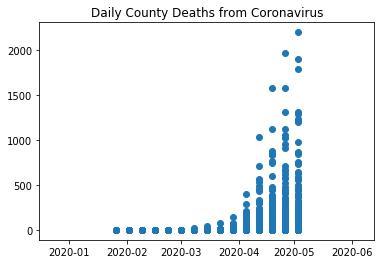

In [231]:
plt.scatter(df_joined['date'],df_joined['deaths'])
plt.title("Daily County Deaths from Coronavirus")
plt.show()

## Modeling

**Data Cleaning for Models**

**Columns**
To determine the importance of particulate matter on error rates, models are separated into two groups. 
- The simple set of features only includes the output variables (deaths and cases) and predictors (date and mean_pm25 level). 
- The more complex models use the demographic variables as well. 
- Then, a last version of the model uses all demographic variables, but removes the particulate matter levels per county. 

In [371]:
simple_columns = ['fips_new','week','date', 'cases', 'deaths','mean_pm25']

In [372]:
demographic_columns = ['fips_new','week','date', 'cases', 'deaths','mean_pm25',
                                  'pct_native','popdensity','older_percent',
                                  'hispanic','Long_','population','population_frac_county', 
                                  'poverty', 'mean_summer_temp','Lat',
                                  'mean_winter_rm', 'education', 'mean_winter_temp',
                                  'pct_owner_occ', 'medhouseholdincome', 'medianhousevalue', 'pct_asian',
                                  'pct_white', 'pct_blk']

In [ ]:
demographic_nopm_columns = ['fips_new','week','date', 'cases', 'deaths',
                                  'pct_native','popdensity','older_percent',
                                  'hispanic','Long_','population','population_frac_county', 
                                  'poverty', 'mean_summer_temp','Lat',
                                  'mean_winter_rm', 'education', 'mean_winter_temp',
                                  'pct_owner_occ', 'medhouseholdincome', 'medianhousevalue', 'pct_asian',
                                  'pct_white', 'pct_blk']

In [ ]:
df_daylevel = df_joined_daylevel[['date','deaths']]
df_daylevel = df_daylevel.groupby(['date']).agg(
    { 'deaths':'sum'}
)

In [373]:
df_simple = df_joined[simple_columns]

df_simple = df_simple.groupby(['fips_new','week']).agg(
    deaths=('deaths', 'sum'),
    mean_pm25 = ('mean_pm25','mean'))

df_simple=df_simple.reset_index()

In [394]:
X_train_simple = df_simple.loc[df_simple['week']<18 ][['mean_pm25','week']]
y_train_simple = df_simple.loc[df_simple['week']<18][['deaths']]
X_test_simple = df_simple.loc[df_simple['week']==18][['mean_pm25','week']]
y_test = df_simple.loc[df_simple['week']==18][['deaths']] #only need to filter y_test once for all models


In [375]:
df_demographic = df_joined[demographic_columns]

df_demographic = df_demographic.groupby(['fips_new','week']).agg(
    {
        'cases':'sum',
        'deaths':'sum',
        'mean_pm25':'mean',
        'pct_native':'mean',
        'popdensity':'mean',
        'older_percent':'mean',
        'hispanic':'mean',
        'Long_':'mean',
        'population':'mean',
        'population_frac_county':'mean', 
        'poverty':'mean', 
        'mean_summer_temp':'mean',
        'Lat':'mean',
        'mean_winter_rm':'mean', 
        'education':'mean', 
        'mean_winter_temp':'mean',
        'pct_owner_occ':'mean', 
        'medhouseholdincome':'mean', 
        'medianhousevalue':'mean', 
        'pct_asian':'mean',
        'pct_white':'mean', 
        'pct_blk':'mean'        
    })

df_demographic=df_demographic.reset_index()

In [376]:
X_train_demographic = df_demographic.loc[df_demographic['week']<18].drop(columns = ['fips_new','cases','deaths'])
y_train_demographic = df_demographic.loc[df_demographic['week']<18][['deaths']]
X_test_demographic = df_demographic.loc[df_demographic['week']==18].drop(columns = ['fips_new','cases','deaths'])


In [ ]:
df_demographic_nopm = df_joined[demographic_nopm_columns]

df_demographic_nopm = df_demographic_nopm.groupby(['fips_new','week']).agg(
    {
        'cases':'sum',
        'deaths':'sum',
        'pct_native':'mean',
        'popdensity':'mean',
        'older_percent':'mean',
        'hispanic':'mean',
        'Long_':'mean',
        'population':'mean',
        'population_frac_county':'mean', 
        'poverty':'mean', 
        'mean_summer_temp':'mean',
        'Lat':'mean',
        'mean_winter_rm':'mean', 
        'education':'mean', 
        'mean_winter_temp':'mean',
        'pct_owner_occ':'mean', 
        'medhouseholdincome':'mean', 
        'medianhousevalue':'mean', 
        'pct_asian':'mean',
        'pct_white':'mean', 
        'pct_blk':'mean'        
    })

df_demographic_nopm=df_demographic_nopm.reset_index()


In [ ]:
X_train_demographic_nopm = df_demographic_nopm.loc[df_demographic_nopm['week']<18].drop(columns = ['fips_new','cases','deaths'])
y_train_demographic_nopm = df_demographic_nopm.loc[df_demographic_nopm['week']<18][['deaths']]
X_test_demographic_nopm = df_demographic_nopm.loc[df_demographic_nopm['week']==18].drop(columns = ['fips_new','cases','deaths'])


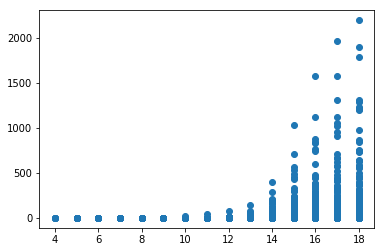

In [378]:
plt.scatter(df_simple['week'],df_simple['deaths'])
plt.title("")
plt.show()

#### Linear Regression

**Model 1:**
Simple Model uses only week number and the mean pm25 levels by county

In [379]:
from sklearn.linear_model import LinearRegression
linear_simple = LinearRegression().fit(X_train_simple, y_train_simple)
y_pred_simple = model_simple.predict(X_test_simple)

In [380]:
from sklearn.metrics import mean_squared_error
mse_score_linear_simple = mean_squared_error(y_test, y_pred_simple)
mse_score_linear_simple #very bad score!

10430.460991883792

**Model 2:**
Add in demographic variables

In [381]:
linear_demographic = LinearRegression().fit(X_train_demographic, y_train_demographic)
y_pred_demographic = model_demographic.predict(X_test_demographic)

In [382]:
mse_score_linear_demographic = mean_squared_error(y_test, y_pred_demographic)
mse_score_linear_demographic #pretty bad score!

8755.195509315537

In [383]:
print('Linear Regression predicted deaths, simple features: ', 
      round(y_pred_simple.sum().sum(),0)) 

print('Random Forest predicted deaths, add demographic features: ', 
      round(y_pred_demographic.sum(),0)) 

print("Actual deaths: ", y_test['deaths'].values.sum())

Linear Regression predicted deaths, simple features:  41153.0
Random Forest predicted deaths, add demographic features:  57867.0
Actual deaths:  48829


#### Decision Tree Models

In [384]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

# Training classifiers
boosting_simple = GradientBoostingRegressor(random_state=1, n_estimators=15).fit(X_train_simple.values, y_train_simple.values)
boosting_demographic = GradientBoostingRegressor(random_state=1, n_estimators=15).fit(X_train_demographic.values, y_train_demographic.values)
rf_simple = RandomForestRegressor(random_state=1, n_estimators=15).fit(X_train_simple.values, y_train_simple.values)
rf_demographic = RandomForestRegressor(random_state=1, n_estimators=15).fit(X_train_demographic.values, y_train_demographic.values)


/Users/ericenglin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/ericenglin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/ericenglin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/Users/ericenglin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ra

In [385]:
y_pred_boosting_simple = boosting_simple.predict(X_test_simple.values)
y_pred_boosting_demographic = boosting_demographic.predict(X_test_demographic.values)
y_pred_rf_simple = rf_simple.predict(X_test_simple.values)
y_pred_rf_demographic = rf_demographic.predict(X_test_demographic.values)

In [386]:
mse_score_boosting_simple = mean_squared_error(y_test, y_pred_boosting_simple)
mse_score_boosting_demographic = mean_squared_error(y_test, y_pred_boosting_demographic)
mse_score_rf_simple = mean_squared_error(y_test, y_pred_rf_simple)
mse_score_rf_demographic = mean_squared_error(y_test, y_pred_rf_demographic)

print('Boosting, simple features: ', round(mse_score_boosting_simple,0)) 
print('Boosting, add demographic features: ', round(mse_score_boosting_demographic,0)) 
print('Random Forest, simple features: ', round(mse_score_rf_simple,0)) 
print('Random Forest, add demographic features: ', round(mse_score_rf_demographic,0)) 

Boosting, simple features:  9001.0
Boosting, add demographic features:  4929.0
Random Forest, simple features:  1934.0
Random Forest, add demographic features:  1093.0


In [387]:
print('Boosting predicted deaths, simple features: ', 
      round(y_pred_boosting_simple.sum(),0))

print('Boosting predicted deaths, add demographic features: ', 
      round(y_pred_boosting_demographic.sum(),0)) 

print('Random Forest predicted deaths, simple features: ', 
      round(y_pred_rf_simple.sum(),0)) 

print('Random Forest predicted deaths, add demographic features: ', 
      round(y_pred_rf_demographic.sum(),0)) 

print("Actual deaths: ", y_test['deaths'].values.sum())

Boosting predicted deaths, simple features:  29623.0
Boosting predicted deaths, add demographic features:  23522.0
Random Forest predicted deaths, simple features:  35765.0
Random Forest predicted deaths, add demographic features:  35393.0
Actual deaths:  48829


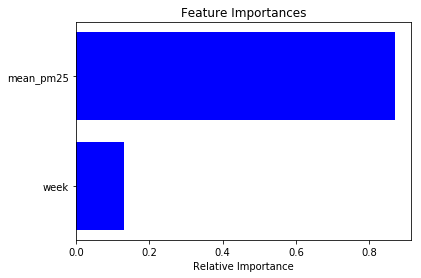

In [388]:
features = X_test_simple.columns
importances = rf_simple.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

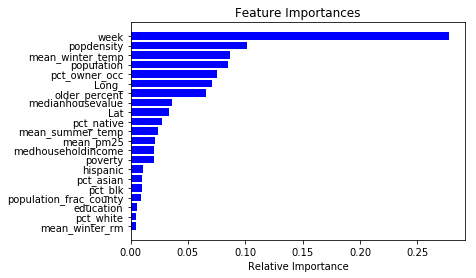

In [389]:
features = X_test_demographic.columns
importances = rf_demographic.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

#### RNNs

Code modified from tensorflow page: 
[LSTM Time Series](https://www.tensorflow.org/tutorials/structured_data/time_series)

In [564]:
df_simple = df_simple.sort_values(by=['fips_new','week'],ascending=True)

In [496]:
import tensorflow.keras.utils as utils

In [555]:
uni_data = df_simple[['deaths','week']]
uni_data.index = uni_data['week']
uni_data=uni_data[['deaths']]
uni_data = uni_data.values

In [550]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)


In [598]:
df_simple_rnn = df_joined_daylevel[['date','deaths']]
df_simple_rnn = df_simple_rnn.groupby(['date']).agg(
    { 'deaths':'sum'}
)
df_simple_rnn.shape

(109, 1)

In [1113]:
uni_data = df_simple_rnn
uni_data=uni_data[['deaths']]
uni_data = uni_data.values
uni_data = uni_data[35:]

In [1114]:
uni_data.shape

(74, 1)

In [1089]:
def create_time_steps(length):
    return list(range(-length, 0))


In [1090]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                   label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt


In [1091]:
def baseline(history):
    return np.mean(history)


In [1118]:
TRAIN_SPLIT=55
univariate_past_history = 10
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)

x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)


In [1119]:
x_train_uni.shape, x_val_uni.shape

((45, 10, 1), (9, 10, 1))

<module 'matplotlib.pyplot' from '/Users/ericenglin/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

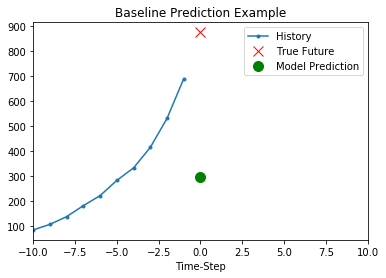

In [1120]:
show_plot([x_train_uni[20], y_train_uni[20], baseline(x_train_uni[20])], 0,
           'Baseline Prediction Example')


In [1121]:
import tensorflow as tf
BATCH_SIZE = 1
BUFFER_SIZE = 100

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()



In [1122]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(200, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1, activation='exponential')
])

simple_lstm_model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mae')
simple_lstm_model.summary()

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_44 (LSTM)               (None, 200)               161600    
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [1123]:
EVALUATION_INTERVAL = 100
EPOCHS = 30

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=100)


Train for 100 steps, validate for 100 steps
Epoch 1/30
100/100 [==============================] - 2s 19ms/step - loss: 5876.3113 - val_loss: 49194.4339
Epoch 2/30
100/100 [==============================] - 1s 6ms/step - loss: 5118.8510 - val_loss: 49231.0952
Epoch 3/30
100/100 [==============================] - 1s 6ms/step - loss: 4603.5758 - val_loss: 46419.2997
Epoch 4/30
100/100 [==============================] - 1s 6ms/step - loss: 3452.1191 - val_loss: 41948.7130
Epoch 5/30
100/100 [==============================] - 1s 6ms/step - loss: 3339.1978 - val_loss: 41696.4494
Epoch 6/30
100/100 [==============================] - 1s 6ms/step - loss: 2855.8794 - val_loss: 40911.5159
Epoch 7/30
100/100 [==============================] - 1s 7ms/step - loss: 2567.5986 - val_loss: 43477.1241
Epoch 8/30
100/100 [==============================] - 1s 6ms/step - loss: 3417.7100 - val_loss: 42948.0784
Epoch 9/30
100/100 [==============================] - 1s 7ms/step - loss: 3315.5418 - val_loss: 465

tf.Tensor([52044], shape=(1,), dtype=int64)
[11641.931]


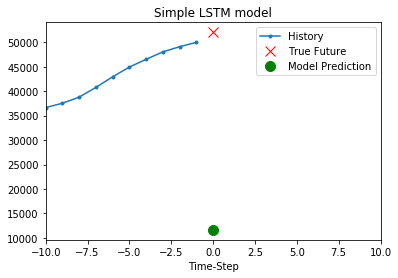

In [1124]:
for x, y in val_univariate.take(1):
    #print(x[0])
    print(y[0])
    print(simple_lstm_model.predict(x)[0])
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
    plot.show()


In [1125]:
count = 6
lstm_simple_preds = []

temp_preds = x_val_uni[-1]
for t in range(110,270):
    #print(temp_preds)
    yhat = simple_lstm_model.predict(temp_preds.reshape(1,10,1))
    temp_preds = temp_preds[1:]
    temp_preds= np.append(temp_preds,yhat)
    count+=1
    if count % 7 ==0:
        lstm_simple_preds.append(yhat[0][0])


In [1126]:
extrapolation_df['LSTM_Simple']=lstm_simple_preds


**LSTM with Mean PM 25 Levels**

In [1157]:
df_joined_daylevel['fips_new'].value_counts()

53061    109
17031    106
06059    105
06037    104
04013    104
        ... 
19147      1
19071      1
32017      1
48389      1
48267      1
Name: fips_new, Length: 2878, dtype: int64

In [1165]:
df_lstm_simple.loc[df_lstm_simple['fips_new']=='53061']['mean_pm25'].unique()[0]


6.39109691627914

In [1166]:
df_lstm_simple.head()

,fips_new,date,deaths,mean_pm25
0,53061,2020-01-21,0,6.391097
1,53061,2020-01-22,0,6.391097
2,53061,2020-01-23,0,6.391097
3,17031,2020-01-24,0,13.370310
4,53061,2020-01-24,0,6.391097


In [1231]:
df_lstm_simple = df_joined_daylevel[simple_columns].drop(columns = 
                                            ['week','cases'])

unique_date_list = df_joined_daylevel.date.unique().tolist()
date_list = df_lstm_simple['date'].tolist()
fips_list = df_lstm_simple['fips_new'].tolist()
pm25_list = df_lstm_simple['mean_pm25'].tolist()
death_list = df_lstm_simple['deaths'].tolist()
count = 0
for x in df_lstm_simple['fips_new'].unique():
    count+=1
    if count%500 ==0:
        print(x)
        print(len(death_list))
    temp_df = df_lstm_simple.loc[df_lstm_simple['fips_new']==x]
    pm25_level = temp_df['mean_pm25'].unique()[0]
    temp_death_list = [0]*(109-len(temp_df))
    temp_date_list = unique_date_list[:(109-len(temp_df))]
    temp_pm25_list = [pm25_level]*(109-len(temp_df))
    temp_fips_list = [x]*(109-len(temp_df))
    date_list= date_list + temp_date_list
    fips_list=fips_list + temp_fips_list
    pm25_list=pm25_list+temp_pm25_list
    death_list=death_list+temp_death_list            

df_lstm_simple = pd.DataFrame({
    'date':date_list,'fips_new':fips_list,
    'mean_pm25':pm25_list, 'deaths':death_list
})




29019
150152
47151
179325
54069
210654
29117
243956
51045
280275


In [1232]:
df_lstm_simple.shape

(313702, 4)

In [1248]:
#df_lstm_simple = df_lstm_simple.sort_values(by=['fips_new','date'])
df_lstm_simple = df_joined_daylevel[simple_columns].drop(columns = 
                                            ['fips_new'])

df_lstm_simple.index = df_lstm_simple['date']
df_lstm_simple=df_lstm_simple[['deaths','mean_pm25']]
df_lstm_simple

,deaths,mean_pm25
date,,
2020-01-21,0,6.391097
2020-01-22,0,6.391097
2020-01-23,0,6.391097
2020-01-24,0,13.370310
2020-01-24,0,6.391097
...,...,...
2020-05-08,0,3.655962
2020-05-08,0,4.896375
2020-05-08,1,3.867683


#### Extrapolate Models Until August

**Change Test Dataset to have weeks until September**

In [462]:
extrapolation_df = pd.DataFrame()
extrapolation_df['week']=range(18,41)

In [463]:
df_graph = df_joined[['week','deaths']].groupby(['week']).agg(
    deaths=('deaths', 'sum'))

df_graph=df_graph.reset_index()

In [473]:
for model,name in zip(simple_models,['linear','boosting','random forest']):
    temp_pred_list = []
    temp_x_train_df = X_train_simple
    temp_y_train_df = y_train_simple
    for y in range(18,41):
        temp_test_df = X_test_simple
        temp_test_df['week'] = y
        temp_model = model.fit(temp_x_train_df.values, temp_y_train_df.values.ravel())

        temp_y_preds = temp_model.predict(temp_test_df.values)
        temp_week_sums = round(temp_y_preds.sum(),0)
        temp_pred_list.append(temp_week_sums)
        temp_x_train_df=temp_x_train_df.append(temp_test_df)
        temp_y_pred_df = pd.DataFrame({'deaths':temp_y_preds.reshape(-1)})
        temp_y_train_df=temp_y_train_df.append(temp_y_pred_df)
    extrapolation_df[name]=temp_pred_list
    print('done with: ', name)
    
for model,name in zip(demographic_models,['linear dem','boosting dem','random forest dem']):
    temp_pred_list = []
    temp_x_train_df = X_train_demographic
    temp_y_train_df = y_train_demographic
    for y in range(18,41):
        temp_test_df = X_test_demographic
        temp_test_df['week'] = y
        temp_model = model.fit(temp_x_train_df.values, temp_y_train_df.values.ravel())
        temp_y_preds = temp_model.predict(temp_test_df.values)
        temp_week_sums = round(temp_y_preds.sum(),0)
        temp_pred_list.append(temp_week_sums)
        temp_x_train_df=temp_x_train_df.append(temp_test_df)
        temp_y_pred_df = pd.DataFrame({'deaths':temp_y_preds.reshape(-1)})
        temp_y_train_df=temp_y_train_df.append(temp_y_pred_df)
    extrapolation_df[name]=temp_pred_list
    print('done with: ', name)


done with:  linear
done with:  boosting
done with:  random forest
done with:  linear dem
done with:  boosting dem
done with:  random forest dem


In [888]:
temp_y_pred_df.shape, temp_y_train_df.shape[0]/36

((2810, 1), 2186.8888888888887)

In [881]:
X_test_demographic.columns

Index(['week', 'mean_pm25', 'pct_native', 'popdensity', 'older_percent',
       'hispanic', 'Long_', 'population', 'population_frac_county', 'poverty',
       'mean_summer_temp', 'Lat', 'mean_winter_rm', 'education',
       'mean_winter_temp', 'pct_owner_occ', 'medhouseholdincome',
       'medianhousevalue', 'pct_asian', 'pct_white', 'pct_blk'],
      dtype='object')

In [1043]:
extrapolation_df

,week,linear,boosting,random forest,linear dem,boosting dem,random forest dem,ARIMA,LSTM_Simple
0,18,41153.0,29623.0,35765.0,57867.0,23522.0,35393.0,[59153.66707783859],9541.776367
1,19,48743.0,28218.0,36698.0,72245.0,22094.0,35316.0,[70909.4172005092],9541.868164
2,20,56334.0,27628.0,36978.0,86624.0,22113.0,35721.0,[82142.14990425466],9541.868164
3,21,63924.0,27186.0,37072.0,101002.0,22130.0,35818.0,[92958.52352308914],9541.868164
4,22,71515.0,27025.0,37131.0,115380.0,21615.0,35762.0,[103427.73030284763],9541.868164
5,23,79105.0,26962.0,37167.0,129758.0,21707.0,35760.0,[113575.52972318421],9541.868164
6,24,86696.0,27062.0,37212.0,144136.0,21687.0,35772.0,[123427.2277193256],9541.868164
7,25,94286.0,27221.0,37279.0,158514.0,21238.0,35762.0,[133006.07526894764],9541.868164
8,26,101877.0,27039.0,37366.0,172892.0,21229.0,35766.0,[142332.4417315298],9541.868164
9,27,109467.0,26942.0,37334.0,187271.0,21265.0,35765.0,[151424.7662813168],9541.868164


In [ ]:
#add polynomial regression
#normalize the variables

In [872]:
from statsmodels.tsa.arima_model import ARIMA
count = 6
arima_preds = []
train = df_daylevel.values
history = [x for x in train]
for t in range(110,270):
    count +=1
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    history.append(yhat)
    if count % 7 ==0:
        arima_preds.append(yhat)

extrapolation_df['ARIMA']=arima_preds

/Users/ericenglin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available



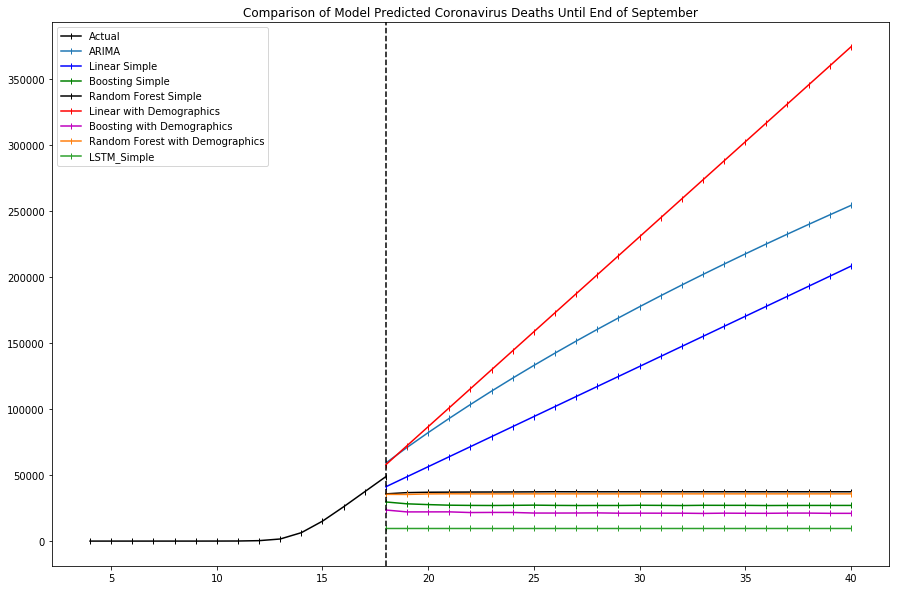

In [1044]:
import matplotlib.pyplot as plt
import numpy as np
 
fig=plt.figure(figsize=(15, 10))
ax=fig.add_subplot(111)

ax.plot(df_graph['week'],df_graph['deaths'],marker="|",label='Actual',c='k',fillstyle='none')
ax.plot(extrapolation_df['week'],extrapolation_df['ARIMA'],marker="|",label='ARIMA',fillstyle='none')
ax.plot(extrapolation_df['week'],extrapolation_df['linear'],c='b',marker="|",label='Linear Simple',fillstyle='none')
ax.plot(extrapolation_df['week'],extrapolation_df['boosting'],c='g',marker="|",label='Boosting Simple')
ax.plot(extrapolation_df['week'],extrapolation_df['random forest'],c='k',marker="|",label='Random Forest Simple')
ax.plot(extrapolation_df['week'],extrapolation_df['linear dem'],c='r',marker="|",label='Linear with Demographics')
ax.plot(extrapolation_df['week'],extrapolation_df['boosting dem'],c='m',marker="|",label='Boosting with Demographics',fillstyle='none')
ax.plot(extrapolation_df['week'],extrapolation_df['random forest dem'],marker="|",label='Random Forest with Demographics')
ax.plot(extrapolation_df['week'],extrapolation_df['LSTM_Simple'],marker="|",label='LSTM_Simple',fillstyle='none')
ax.axvline(x=18, color='k', linestyle='--')

plt.title("Comparison of Model Predicted Coronavirus Deaths Until End of September") #excluding 28 localities (NYC)
plt.legend(loc=2)
plt.show()


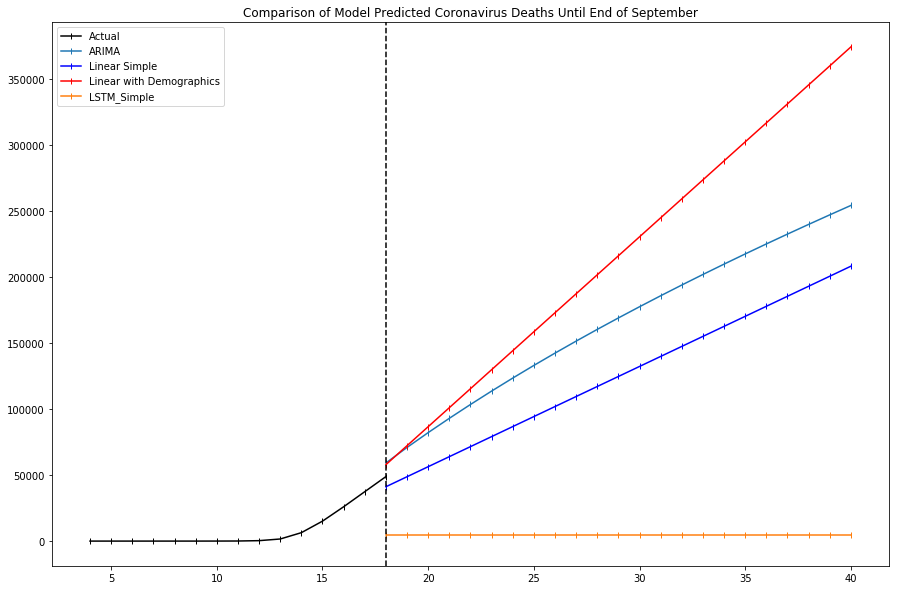

In [1053]:
import matplotlib.pyplot as plt
import numpy as np
 
fig=plt.figure(figsize=(15, 10))
ax=fig.add_subplot(111)

ax.plot(df_graph['week'],df_graph['deaths'],marker="|",label='Actual',c='k',fillstyle='none')
ax.plot(extrapolation_df['week'],extrapolation_df['ARIMA'],marker="|",label='ARIMA',fillstyle='none')
ax.plot(extrapolation_df['week'],extrapolation_df['linear'],c='b',marker="|",label='Linear Simple',fillstyle='none')
ax.plot(extrapolation_df['week'],extrapolation_df['linear dem'],c='r',marker="|",label='Linear with Demographics')
ax.plot(extrapolation_df['week'],extrapolation_df['LSTM_Simple'],marker="|",label='LSTM_Simple',fillstyle='none')
ax.axvline(x=18, color='k', linestyle='--')

plt.title("Comparison of Model Predicted Coronavirus Deaths Until End of September") #excluding 28 localities (NYC)
plt.legend(loc=2)
plt.show()
